In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
import math
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score as f1
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import roc_auc_score

In [129]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


# 0. Getting all neccessary models, standarizer, encoder used during training

In [130]:
credit_record = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/updated_credit_record.csv')

# -----------------------------------------------------------------------------------------


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/OHE_CAT_1.sav'
OHE_CAT_1 = pickle.load(open(filename, 'rb'))

filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/OHE_CAT_OCC.sav'
OHE_CAT_OCC = pickle.load(open(filename, 'rb'))


# ------------------------------------------------------------------------------------------


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/lab_enc_gender.sav'
lab_enc_gender = pickle.load(open(filename, 'rb'))


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/lab_enc_car.sav'
lab_enc_car = pickle.load(open(filename, 'rb'))


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/lab_enc_reality.sav'
lab_enc_reality = pickle.load(open(filename, 'rb'))


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/lab_enc_work_phone.sav'
lab_enc_work_phone = pickle.load(open(filename, 'rb'))


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/lab_enc_phone.sav'
lab_enc_phone = pickle.load(open(filename, 'rb'))


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/lab_enc_email.sav'
lab_enc_email = pickle.load(open(filename, 'rb'))


# ------------------------------------------------------------------------------------------


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/standard_scaler.sav'
standard_scaler = pickle.load(open(filename, 'rb'))


# ------------------------------------------------------------------------------------------


filename = '/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/finalized_model_DT.sav'
clf = pickle.load(open(filename, 'rb'))

In [131]:
application_record = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/application_record.csv')
X = application_record
# X = application_record.iloc[0]
# X = X.to_frame().T

In [132]:
X.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [134]:
def get_ohe(df,categorical_cols,ohe):
    temp_df = pd.DataFrame(data=ohe.transform(df[categorical_cols]), columns=ohe.get_feature_names_out())
    df.drop(columns=categorical_cols, axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

# 1. final_fun_1

In [135]:
application_record = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/application_record.csv')
X = application_record
X = application_record.iloc[0:2]
# X = X.to_frame().T

In [136]:

def final_fun_1(X):

  """
  Replacing null values with "NAN" for occupation type.
  We found this is the best imputation technique.
  """
  # X = X.replace(np.nan, 'NAN', regex=True)
  X["OCCUPATION_TYPE"].fillna("NAN",inplace = True)


  """
  Converting birthdate in days into age
  """
  X["DAYS_BIRTH"] = X["DAYS_BIRTH"]//(-365)
  X.rename(columns = {'DAYS_BIRTH':'AGE'}, inplace = True)


  """
  Converting number of days employed into years
  """
  X["YEARS_EMPLOYED"] = X["DAYS_EMPLOYED"]//(-365)
  year_employed_list = X["YEARS_EMPLOYED"].to_list()
  age_list = X["AGE"].to_list()
  temp_list = []
  # replacing all negative YEARS_EMPLOYED by their AGE
  for i,each in enumerate(year_employed_list):
    if each < 0:
      temp_list.append((-1)*age_list[i])
    else:
      temp_list.append(each)
  X["YEARS_EMPLOYED"] = temp_list
  X = X.drop(['DAYS_EMPLOYED'],axis = 1)


  """ 
  All the applicants in train set had mobile phones.
  So, ignored this feature.
  """
  X.drop(['FLAG_MOBIL'],axis=1)


  """
  credit_record
  """
  credit_record = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/updated_credit_record.csv')  
  credit_record = credit_record.value_counts(subset=['ID', 'STATUS']).unstack(fill_value=0)
  merged_data = X.merge(credit_record, how='left', on=['ID'])
  merged_data["Bad_Debt"].fillna(0,inplace = True)
  merged_data["Good_Debt"].fillna(0,inplace = True)
  merged_data["Neutral_Debt"].fillna(0,inplace = True)
  X = merged_data


  """
  One Hot Encoding for CATEGORICAL DATA
  """
  categorical_cols = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
  X = get_ohe(X,categorical_cols,OHE_CAT_1)
  categorical_cols = ['OCCUPATION_TYPE']
  X = get_ohe(X,categorical_cols,OHE_CAT_OCC)


  """
  LABEL ENCODER FOR BINARY CATEGORICAL VARIABLE
  """
  X['CODE_GENDER'] = lab_enc_gender.transform(X['CODE_GENDER'])
  X['FLAG_OWN_CAR'] = lab_enc_car.transform(X['FLAG_OWN_CAR'])
  X['FLAG_OWN_REALTY'] = lab_enc_reality.transform(X['FLAG_OWN_REALTY'])
  X['FLAG_WORK_PHONE'] = lab_enc_work_phone.transform(X['FLAG_WORK_PHONE'])
  X['FLAG_PHONE'] = lab_enc_phone.transform(X['FLAG_PHONE'])
  X['FLAG_EMAIL'] = lab_enc_email.transform(X['FLAG_EMAIL'])


  """
  STANDARIZING NUMERICAL FEATURES
  """
  col_names = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL','AGE','YEARS_EMPLOYED','CNT_FAM_MEMBERS']
  X[col_names] = standard_scaler.transform(X[col_names])

  """
  Dropping the ID feature
  """
  X = X.drop("ID",1) 


  y_pred = clf.predict(X)
  return y_pred

In [137]:
y_pred = final_fun_1(X)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [138]:
y_pred

array([1., 1.])

# 2.final_fun_2

In [139]:
application_record = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/application_record.csv')
X = application_record.iloc[0:5000]
# X = X.to_frame().T

In [140]:
# creating the target variable for the given inputs

credit_record_temp = credit_record.value_counts(subset=['ID', 'STATUS']).unstack(fill_value=0)
credit_record_temp.loc[(credit_record_temp['Good_Debt'] > credit_record_temp['Neutral_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit_record_temp.loc[(credit_record_temp['Good_Debt'] > credit_record_temp['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit_record_temp.loc[(credit_record_temp['Neutral_Debt'] > credit_record_temp['Good_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0
credit_record_temp.loc[(credit_record_temp['Neutral_Debt'] > credit_record_temp['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit_record_temp.loc[(credit_record_temp['Bad_Debt'] > credit_record_temp['Good_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0
credit_record_temp.loc[(credit_record_temp['Bad_Debt'] > credit_record_temp['Neutral_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0

merged_data = X.merge(credit_record_temp, how='inner', on=['ID'])
merged_data = merged_data.drop(['Good_Debt','Neutral_Debt','Bad_Debt'],axis = 1)

In [141]:
# Defining X and Y accordingly as for many data points we donot have the target variable as those applications doesnot have any previous record

X = merged_data.iloc[:,:-1]
Y = merged_data.iloc[:,-1]



print(X.shape)
print(Y.shape)

(4478, 18)
(4478,)


In [142]:
def final_fun_2(X,Y):

  """
  Replacing null values with "NAN" for occupation type.
  We found this is the best imputation technique.
  """
  # X = X.replace(np.nan, 'NAN', regex=True)
  X["OCCUPATION_TYPE"].fillna("NAN",inplace = True)


  """
  Converting birthdate in days into age
  """
  X["DAYS_BIRTH"] = X["DAYS_BIRTH"]//(-365)
  X.rename(columns = {'DAYS_BIRTH':'AGE'}, inplace = True)


  """
  Converting number of days employed into years
  """
  X["YEARS_EMPLOYED"] = X["DAYS_EMPLOYED"]//(-365)
  year_employed_list = X["YEARS_EMPLOYED"].to_list()
  age_list = X["AGE"].to_list()
  temp_list = []
  # replacing all negative YEARS_EMPLOYED by their AGE
  for i,each in enumerate(year_employed_list):
    if each < 0:
      temp_list.append((-1)*age_list[i])
    else:
      temp_list.append(each)
  X["YEARS_EMPLOYED"] = temp_list
  X = X.drop(['DAYS_EMPLOYED'],axis = 1)


  """ 
  All the applicants in train set had mobile phones.
  So, ignored this feature.
  """
  X.drop(['FLAG_MOBIL'],axis=1)


  """
  credit_record
  """
  credit_record = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 1/updated_credit_record.csv')  
  credit_record = credit_record.value_counts(subset=['ID', 'STATUS']).unstack(fill_value=0)
  merged_data = X.merge(credit_record, how='left', on=['ID'])
  merged_data["Bad_Debt"].fillna(0,inplace = True)
  merged_data["Good_Debt"].fillna(0,inplace = True)
  merged_data["Neutral_Debt"].fillna(0,inplace = True)
  X = merged_data


  """
  One Hot Encoding for CATEGORICAL DATA
  """
  categorical_cols = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
  X = get_ohe(X,categorical_cols,OHE_CAT_1)
  categorical_cols = ['OCCUPATION_TYPE']
  X = get_ohe(X,categorical_cols,OHE_CAT_OCC)


  """
  LABEL ENCODER FOR BINARY CATEGORICAL VARIABLE
  """
  X['CODE_GENDER'] = lab_enc_gender.transform(X['CODE_GENDER'])
  X['FLAG_OWN_CAR'] = lab_enc_car.transform(X['FLAG_OWN_CAR'])
  X['FLAG_OWN_REALTY'] = lab_enc_reality.transform(X['FLAG_OWN_REALTY'])
  X['FLAG_WORK_PHONE'] = lab_enc_work_phone.transform(X['FLAG_WORK_PHONE'])
  X['FLAG_PHONE'] = lab_enc_phone.transform(X['FLAG_PHONE'])
  X['FLAG_EMAIL'] = lab_enc_email.transform(X['FLAG_EMAIL'])


  """
  STANDARIZING NUMERICAL FEATURES
  """
  col_names = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL','AGE','YEARS_EMPLOYED','CNT_FAM_MEMBERS']
  X[col_names] = standard_scaler.transform(X[col_names])

  """
  Dropping the ID feature
  """
  X = X.drop("ID",1) 


  y_pred = clf.predict(X)
  

  """
  METRICS:
  """
  cm = confusion_matrix(Y,y_pred)
  print("ACCURACY SCORE-->",accuracy_score(Y,y_pred))
  sn.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Blues')
  print(classification_report(Y,y_pred))

  return roc_auc_score(Y, y_pred)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


ACCURACY SCORE--> 0.9991067440821796
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83        10
         1.0       1.00      1.00      1.00      4468

    accuracy                           1.00      4478
   macro avg       0.86      1.00      0.92      4478
weighted avg       1.00      1.00      1.00      4478

THE AUC ROC score is  0.9995523724261415


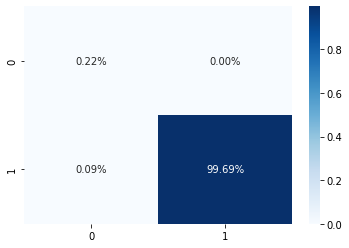

In [143]:
metrics = final_fun_2(X,Y.to_list())
print("THE AUC ROC score is ",metrics)